In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
img_size=128
def load_images_from_folder(folder_path, label=None):
    images = []
    labels = []

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return images, labels

    # Get all noise-type subfolders (e.g., motion_blur, salt_and_pepper_noise)
    noise_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

    # Load images from each noise-type subfolder
    for noise_folder in noise_folders:
        noise_path = os.path.join(folder_path, noise_folder)

        # Get all image files in the folder (e.g., .jpg, .jpeg, .png)
        image_files = [f for f in os.listdir(noise_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Loading {len(image_files)} images from {noise_path}")

        for filename in image_files:
            img_path = os.path.join(noise_path, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Failed to load image: {img_path}")  # Log failed images
            else:
                # Resize image to the desired size (e.g., 128x128)
                image = cv2.resize(image, (img_size, img_size))
                # Convert image from BGR (OpenCV default) to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                if label is not None:
                    labels.append(label)

    print(f"Loaded {len(images)} images from {folder_path}")
    return images, labels

In [5]:
train_dir = "/kaggle/input/cvdata/Dataset/Dataset/dataset/training_set"
test_dir = "/kaggle/input/cvdata/Dataset/Dataset/dataset/test_set"

Loading 4000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/training_set/cats/salt_and_pepper_noise
Loading 4000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/training_set/cats/motion_blur
Loaded 8000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/training_set/cats
Loading 4000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/training_set/dogs/salt_and_pepper_noise
Loading 4000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/training_set/dogs/motion_blur
Loaded 8000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/training_set/dogs
Loading 1000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/test_set/cats/salt_and_pepper_noise
Loading 1000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/test_set/cats/motion_blur
Loaded 2000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/test_set/cats
Loading 1000 images from /kaggle/input/cvdata/Dataset/Dataset/dataset/test_set/dogs/salt_and_pepper_noise
Loading 1000 im

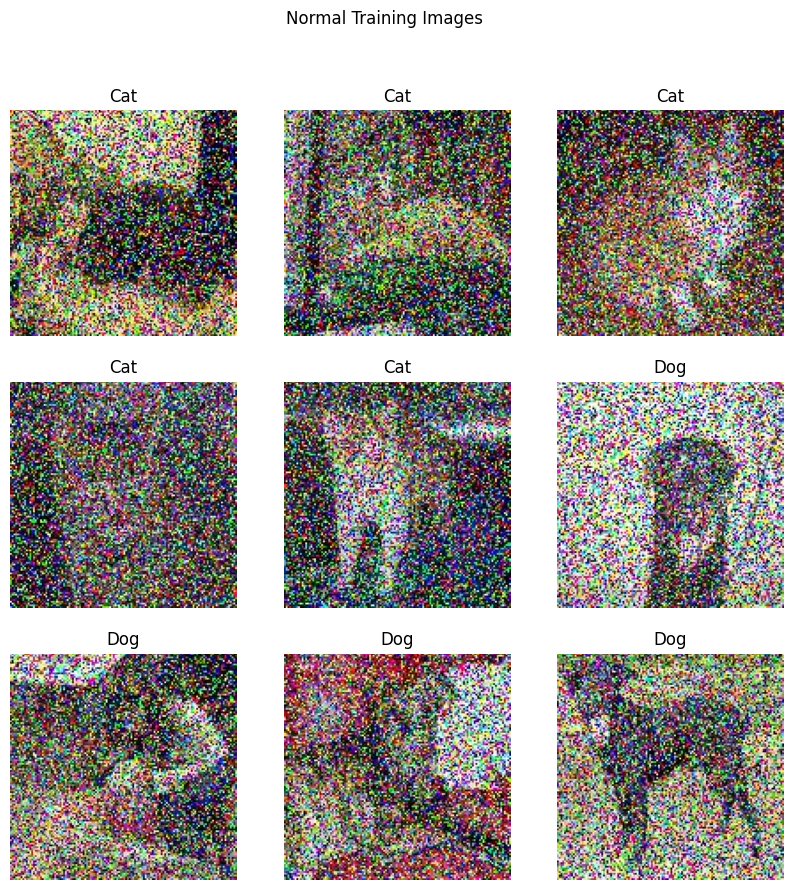

In [6]:
cat_train_images, cat_train_labels = load_images_from_folder(os.path.join(train_dir, 'cats'), label=0)
dog_train_images, dog_train_labels = load_images_from_folder(os.path.join(train_dir, 'dogs'), label=1)

# Combine training data
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Load test images for both classes
cat_test_images, cat_test_labels = load_images_from_folder(os.path.join(test_dir, 'cats'), label=0)
dog_test_images, dog_test_labels = load_images_from_folder(os.path.join(test_dir, 'dogs'), label=1)

# Combine test data
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)

# Visualize normal training images
plt.figure(figsize=(10, 10))
cat_indexes = np.where(y_train == 0)[0][:5]
dog_indexes = np.where(y_train == 1)[0][:4]
sample_indexes = np.concatenate([cat_indexes, dog_indexes])

for i, idx in enumerate(sample_indexes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[idx])
    plt.title("Cat" if y_train[idx] == 0 else "Dog")
    plt.axis("off")
plt.suptitle("Normal Training Images")
plt.show()

In [7]:
categories = ['cats', 'dogs']
noise_types = ['salt_and_pepper_noise', 'motion_blur']

In [8]:

def preprocess_salt_pepper(image):
    # Step 1: Apply median blur to reduce salt-and-pepper noise
    img = cv2.medianBlur(image, 7)

    # Step 2: Apply Non-Local Means Denoising
    img = cv2.fastNlMeansDenoisingColored(img, None, 15, 15, 7, 21)

    # Step 3: Sharpen the image
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    # Step 4: Apply Gaussian blur to smooth residual noise
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Step 5: Apply CLAHE for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return img



def preprocess_motion_blur(image, kernel_length=20, angle=0, K=0.01):
    assert len(image.shape) == 3, "Input must be a 3D RGB image."

    # Create the motion blur kernel
    kernel = np.zeros((kernel_length, kernel_length))
    center = kernel_length // 2
    slope = np.tan(np.deg2rad(angle))
    for i in range(kernel_length):
        kernel[center + int(slope * (i - center)), i] = 1
    kernel = kernel / np.sum(kernel)

    # Wiener filter function for each channel
    def wiener_filter(image_channel, kernel, K):
        img_fft = np.fft.fft2(image_channel)
        kernel_fft = np.fft.fft2(kernel, s=image_channel.shape)
        return np.clip(np.fft.ifft2((np.conj(kernel_fft) * img_fft) / (kernel_fft * np.conj(kernel_fft) + K)).real, 0, 255).astype(np.uint8)

    # Apply the Wiener filter to each channel (R, G, B)
    return np.dstack([wiener_filter(image[:,:,i], kernel, K) for i in range(3)])




def preprocess_image(image, noise_type):
    if noise_type == "salt_and_pepper_noise":
        return preprocess_salt_pepper(image)
    elif noise_type == "motion_blur":
        return preprocess_motion_blur(image)
    else:
        raise ValueError("Unknown noise type: choose 'salt_and_pepper' or 'motion_blur'")


In [9]:
original_base_dir = '/kaggle/input/cvdata/Dataset/Dataset/dataset'
processed_base_dir = '/kaggle/output/preprocessed_dataset'  # Make sure this matches your desired output location

In [10]:
def process_and_save_dataset(input_base_dir, output_base_dir, dataset_type):
    """Process and save images for either training or testing dataset"""
    dataset_output_dir = os.path.join(output_base_dir, dataset_type)
    os.makedirs(dataset_output_dir, exist_ok=True)

    for category in categories:
        print(f"\nProcessing {dataset_type} - {category}...")
        category_output_dir = os.path.join(dataset_output_dir, category)
        os.makedirs(category_output_dir, exist_ok=True)

        for noise_type in noise_types:
            print(f"Processing {noise_type}...")
            noise_output_dir = os.path.join(category_output_dir, noise_type)
            os.makedirs(noise_output_dir, exist_ok=True)

            input_dir = os.path.join(input_base_dir, dataset_type, category, noise_type)
            image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

            for img_name in tqdm(image_files, desc=f"{dataset_type}/{category}/{noise_type}"):
                img_path = os.path.join(input_dir, img_name)
                image = cv2.imread(img_path)

                if image is None:
                    print(f"Failed to load image: {img_path}")
                    continue

                processed_image = preprocess_image(image, noise_type)
                output_path = os.path.join(noise_output_dir, img_name)
                success = cv2.imwrite(output_path, processed_image)

                if not success:
                    print(f"Failed to save image: {output_path}")


In [11]:
def visualize_samples(original_base_dir, processed_base_dir, num_samples=3, dataset_type='training_set'):
    """Visualize original and processed samples"""
    for category in categories:
        for noise_type in noise_types:
            original_path = os.path.join(original_base_dir, dataset_type, category, noise_type)
            processed_path = os.path.join(processed_base_dir, dataset_type, category, noise_type)

            if not os.path.exists(original_path) or not os.path.exists(processed_path):
                print(f"Paths don't exist:\nOriginal: {original_path}\nProcessed: {processed_path}")
                continue

            image_files = [f for f in os.listdir(original_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if not image_files:
                continue

            sample_files = random.sample(image_files, min(num_samples, len(image_files)))

            fig = plt.figure(figsize=(15, 5))
            for i, img_name in enumerate(sample_files):
                # Load original image
                orig_path = os.path.join(original_path, img_name)
                orig_img = cv2.imread(orig_path)
                if orig_img is not None:
                    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

                    plt.subplot(2, num_samples, i + 1)
                    plt.imshow(orig_img)
                    plt.title(f"{category.capitalize()}\n({noise_type.replace('_', ' ').capitalize()})\nOriginal")
                    plt.axis('off')

                # Load processed image
                proc_path = os.path.join(processed_path, img_name)
                if os.path.exists(proc_path):
                    proc_img = cv2.imread(proc_path)
                    if proc_img is not None:
                        proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)

                        plt.subplot(2, num_samples, i + 1 + num_samples)
                        plt.imshow(proc_img)
                        plt.title(f"{category.capitalize()}\n({noise_type.replace('_', ' ').capitalize()})\nProcessed")
                        plt.axis('off')

            plt.tight_layout()
            plt.show()

Processing training set...

Processing training_set - cats...
Processing salt_and_pepper_noise...


training_set/cats/salt_and_pepper_noise: 100%|██████████| 4000/4000 [03:54<00:00, 17.06it/s]


Processing motion_blur...


training_set/cats/motion_blur: 100%|██████████| 4000/4000 [00:22<00:00, 174.46it/s]



Processing training_set - dogs...
Processing salt_and_pepper_noise...


training_set/dogs/salt_and_pepper_noise: 100%|██████████| 4000/4000 [03:53<00:00, 17.16it/s]


Processing motion_blur...


training_set/dogs/motion_blur: 100%|██████████| 4000/4000 [00:25<00:00, 159.32it/s]



Processing test set...

Processing test_set - cats...
Processing salt_and_pepper_noise...


test_set/cats/salt_and_pepper_noise: 100%|██████████| 1000/1000 [00:58<00:00, 17.01it/s]


Processing motion_blur...


test_set/cats/motion_blur: 100%|██████████| 1000/1000 [00:06<00:00, 162.36it/s]



Processing test_set - dogs...
Processing salt_and_pepper_noise...


test_set/dogs/salt_and_pepper_noise: 100%|██████████| 1000/1000 [00:59<00:00, 16.77it/s]


Processing motion_blur...


test_set/dogs/motion_blur: 100%|██████████| 1000/1000 [00:06<00:00, 155.67it/s]



Visualizing samples...


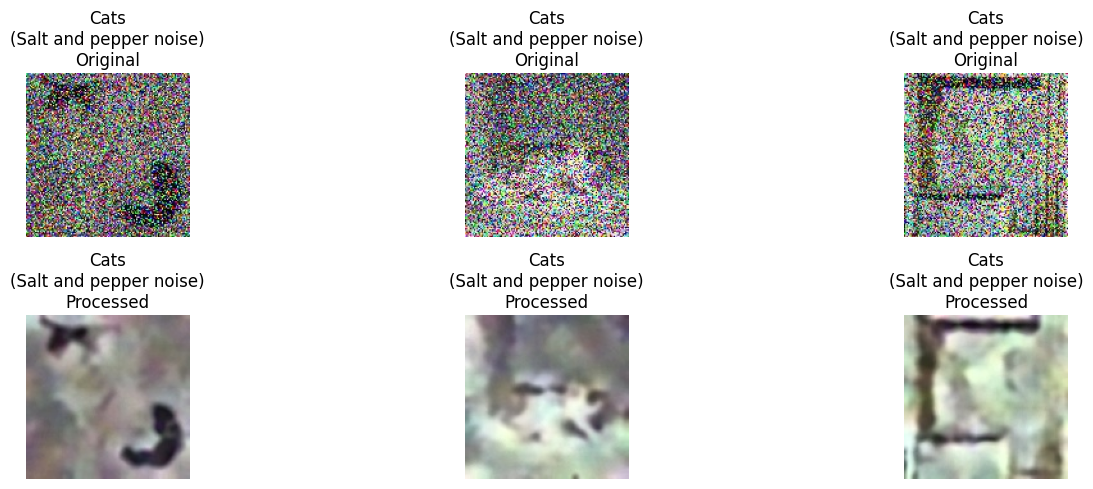

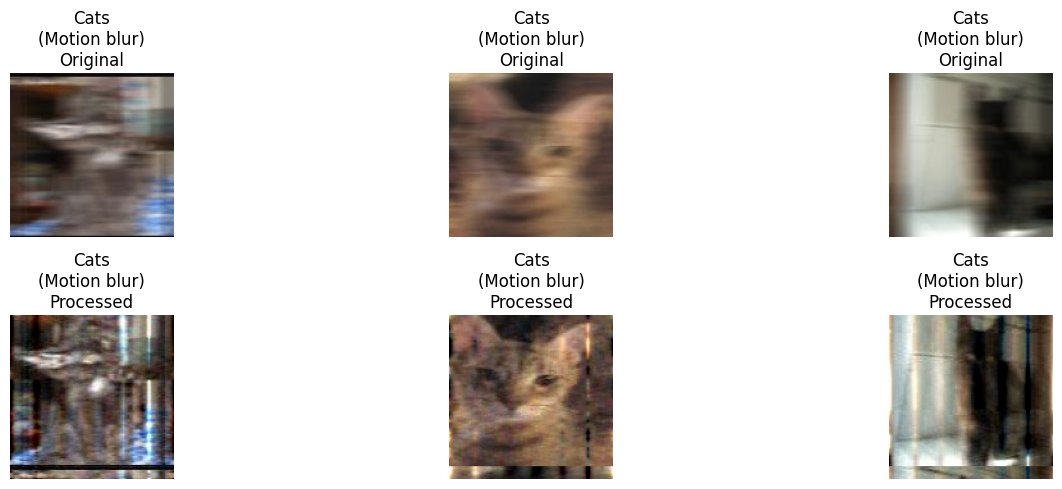

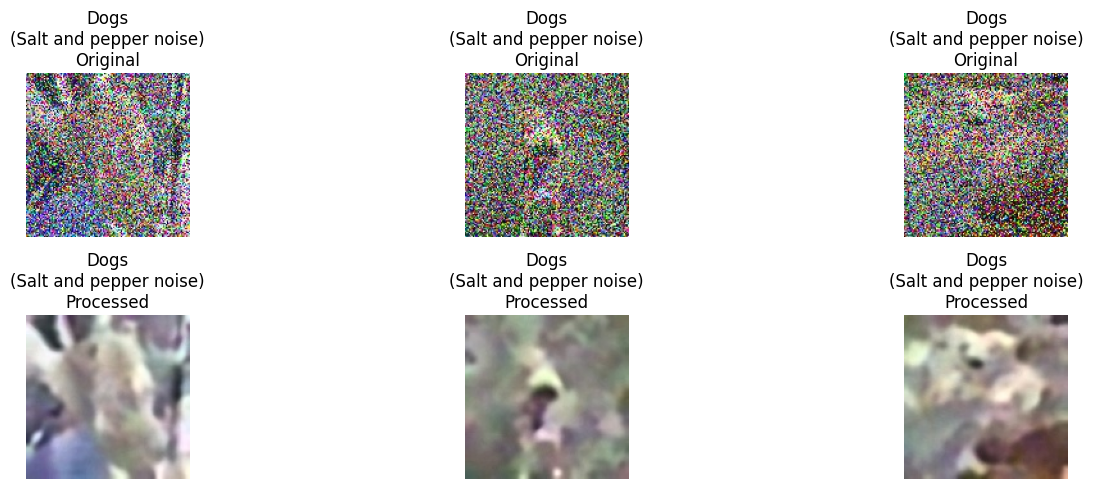

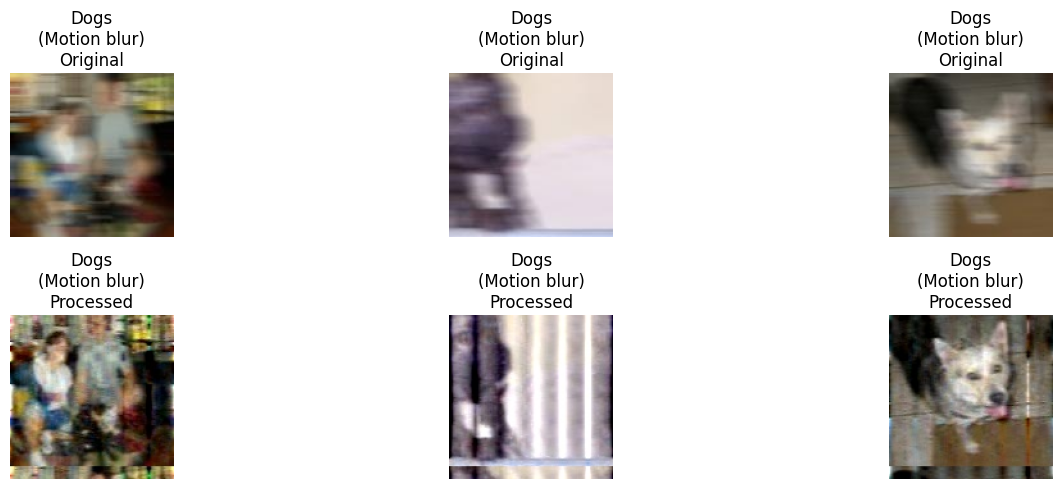

In [12]:
print("Processing training set...")
process_and_save_dataset(original_base_dir, processed_base_dir, 'training_set')

print("\nProcessing test set...")
process_and_save_dataset(original_base_dir, processed_base_dir, 'test_set')

# Then visualize them
print("\nVisualizing samples...")
visualize_samples(original_base_dir, processed_base_dir, num_samples=3, dataset_type='training_set')

In [14]:
cat_train_images, cat_train_labels = load_images_from_folder(os.path.join("/kaggle/output/preprocessed_dataset/training_set", 'cats'), label=0)
dog_train_images, dog_train_labels = load_images_from_folder(os.path.join("/kaggle/output/preprocessed_dataset/training_set", 'dogs'), label=1)


cat_test_images, cat_test_labels = load_images_from_folder(os.path.join("/kaggle/output/preprocessed_dataset/test_set", 'cats'), label=0)
dog_test_images, dog_test_labels = load_images_from_folder(os.path.join("/kaggle/output/preprocessed_dataset/test_set", 'dogs'), label=1)


Loading 4000 images from /kaggle/output/preprocessed_dataset/training_set/cats/salt_and_pepper_noise
Loading 4000 images from /kaggle/output/preprocessed_dataset/training_set/cats/motion_blur
Loaded 8000 images from /kaggle/output/preprocessed_dataset/training_set/cats
Loading 4000 images from /kaggle/output/preprocessed_dataset/training_set/dogs/salt_and_pepper_noise
Loading 4000 images from /kaggle/output/preprocessed_dataset/training_set/dogs/motion_blur
Loaded 8000 images from /kaggle/output/preprocessed_dataset/training_set/dogs
Loading 1000 images from /kaggle/output/preprocessed_dataset/test_set/cats/salt_and_pepper_noise
Loading 1000 images from /kaggle/output/preprocessed_dataset/test_set/cats/motion_blur
Loaded 2000 images from /kaggle/output/preprocessed_dataset/test_set/cats
Loading 1000 images from /kaggle/output/preprocessed_dataset/test_set/dogs/salt_and_pepper_noise
Loading 1000 images from /kaggle/output/preprocessed_dataset/test_set/dogs/motion_blur
Loaded 2000 images

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill any new pixels created by transformations
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # For validation, just rescale

# Create generators for training and validation
train_generator = train_datagen.flow_from_directory(
    '/kaggle/output/preprocessed_dataset/training_set/',  # Path to the training directory
    target_size=(128, 128),  # Resize images to 150x150 (or any desired size)
    batch_size=32,
    class_mode='binary',  # For binary classification (cats vs dogs)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/output/preprocessed_dataset/test_set/',  # Path to the validation directory
    target_size=(128, 128),  # Resize images to 150x150 (or any desired size)
    batch_size=32,
    class_mode='binary',  # For binary classification
    shuffle=False
)



Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,UpSampling2D, BatchNormalization,Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import zipfile
from tqdm import tqdm
from skimage import exposure
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [50]:
# Example of adjusted architecture
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Classification Head
    Flatten(),
    Dense(1024, activation='relu'),  # Increase size of Dense layer
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0002)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [96]:
# Fit the model with the new generator and callbacks
history = model.fit(
    train_generator,
    epochs=70,  # Adjust epochs based on model convergence
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Epoch 1/70
500/500 - 97s - 194ms/step - accuracy: 0.5164 - loss: 0.9605 - val_accuracy: 0.5020 - val_loss: 0.7604 - learning_rate: 2.0000e-04
Epoch 2/70
500/500 - 83s - 167ms/step - accuracy: 0.5436 - loss: 0.6902 - val_accuracy: 0.5410 - val_loss: 0.7266 - learning_rate: 2.0000e-04
Epoch 3/70
500/500 - 84s - 167ms/step - accuracy: 0.5703 - loss: 0.6794 - val_accuracy: 0.6295 - val_loss: 0.6646 - learning_rate: 2.0000e-04
Epoch 4/70
500/500 - 83s - 165ms/step - accuracy: 0.5654 - loss: 0.6895 - val_accuracy: 0.6280 - val_loss: 0.6392 - learning_rate: 2.0000e-04
Epoch 5/70
500/500 - 83s - 166ms/step - accuracy: 0.5715 - loss: 0.6816 - val_accuracy: 0.5105 - val_loss: 1.0583 - learning_rate: 2.0000e-04
Epoch 6/70
500/500 - 83s - 167ms/step - accuracy: 0.5906 - loss: 0.6668 - val_accuracy: 0.6028 - val_loss: 0.6586 - learning_rate: 2.0000e-04
Epoch 7/70
500/500 - 83s - 166ms/step - accuracy: 0.6072 - loss: 0.6571 - val_accuracy: 0.6720 - val_loss: 0.5977 - learning_rate: 2.0000e-04
Epoch 

In [97]:
loss, accuracy = model.evaluate(val_generator)
print(f'Accuracy: {accuracy:.4f}')
print(f'Loss: {loss:.4f}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8644 - loss: 0.3332
Accuracy: 0.8595
Loss: 0.3260


In [101]:
history = model.fit(
    train_generator,
    epochs=70,  # Adjust epochs based on model convergence
    validation_data=val_generator,
    callbacks=[reduce_lr],
    verbose=2
)

Epoch 1/70
500/500 - 96s - 192ms/step - accuracy: 0.5343 - loss: 0.8869 - val_accuracy: 0.5913 - val_loss: 0.6797 - learning_rate: 2.0000e-04
Epoch 2/70
500/500 - 84s - 167ms/step - accuracy: 0.5641 - loss: 0.6818 - val_accuracy: 0.6152 - val_loss: 0.7402 - learning_rate: 2.0000e-04
Epoch 3/70
500/500 - 84s - 167ms/step - accuracy: 0.5836 - loss: 0.6729 - val_accuracy: 0.6137 - val_loss: 0.6601 - learning_rate: 2.0000e-04
Epoch 4/70
500/500 - 84s - 168ms/step - accuracy: 0.5749 - loss: 0.6779 - val_accuracy: 0.5160 - val_loss: 1.3512 - learning_rate: 2.0000e-04
Epoch 5/70
500/500 - 84s - 168ms/step - accuracy: 0.5896 - loss: 0.6692 - val_accuracy: 0.6475 - val_loss: 0.6329 - learning_rate: 2.0000e-04
Epoch 6/70
500/500 - 83s - 166ms/step - accuracy: 0.6044 - loss: 0.6608 - val_accuracy: 0.6072 - val_loss: 1.1000 - learning_rate: 2.0000e-04
Epoch 7/70
500/500 - 83s - 167ms/step - accuracy: 0.6143 - loss: 0.6556 - val_accuracy: 0.6248 - val_loss: 0.6369 - learning_rate: 2.0000e-04
Epoch 

In [102]:
loss, accuracy = model.evaluate(val_generator)
print(f'Accuracy: {accuracy:.4f}')
print(f'Loss: {loss:.4f}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8692 - loss: 0.3863
Accuracy: 0.8655
Loss: 0.3416


In [29]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    filepath='best_model_transfer_learning.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [model_checkpoint, reduce_lr]

In [51]:
history = model.fit(
    train_generator,
    epochs=70,  # Adjust epochs based on model convergence
    validation_data=val_generator,
    callbacks=callbacks

Epoch 1/70
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5355 - loss: 1.4634
Epoch 1: val_loss did not improve from 0.66498
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - accuracy: 0.5356 - loss: 1.4628 - val_accuracy: 0.6173 - val_loss: 0.6861 - learning_rate: 2.0000e-04
Epoch 2/70
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5895 - loss: 0.6772
Epoch 2: val_loss improved from 0.66498 to 0.65521, saving model to best_model_transfer_learning.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.5895 - loss: 0.6772 - val_accuracy: 0.6250 - val_loss: 0.6552 - learning_rate: 2.0000e-04
Epoch 3/70
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6141 - loss: 0.6615
Epoch 3: val_loss did not improve from 0.65521
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 71ms/step - accuracy: 0.6141 - loss: 0.6615 - val_accuracy: 0.6177 - val_loss: 0.6594 - learning_rate: 2.0000e-04
Epoch 4/70
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6151 - loss: 0.6593
